In [1]:
%matplotlib inline


==============================
Rescale, resize, and downscale
==============================

`Rescale` operation resizes an image by a given scaling factor. The scaling
factor can either be a single floating point value, or multiple values - one
along each axis.

`Resize` serves the same purpose, but allows to specify an output image shape
instead of a scaling factor.

Note that when down-sampling an image, `resize` and `rescale` should perform
Gaussian smoothing to avoid aliasing artifacts. See the `anti_aliasing` and
`anti_aliasing_sigma` arguments to these functions.

`Downscale` serves the purpose of down-sampling an n-dimensional image by
integer factors using the local mean on the elements of each block of the size
factors given as a parameter to the function.


In [2]:
import base64
import numpy as np
import io
from PIL import Image

In [3]:
stringdata="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAARElEQVRIS+3SwQkAMAzDwGT/pTuCEJS8lK8xhiM7x7fHe9Pgd/FII9UCPY0mo0KkJKTzSDUZFSIlIZ1HqsmoECkJ6fwBv5IAHZpfiPwAAAAASUVORK5CYII="

In [4]:
string64 = stringdata.split(",")[-1]
string64

'iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAARElEQVRIS+3SwQkAMAzDwGT/pTuCEJS8lK8xhiM7x7fHe9Pgd/FII9UCPY0mo0KkJKTzSDUZFSIlIZ1HqsmoECkJ6fwBv5IAHZpfiPwAAAAASUVORK5CYII='

In [5]:
stringold="iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AAAU2ElEQVR4Xu2dzW4VRxOGm/hPsIiNpQSDcwFZgSCrSLkA9tlBhA32ZdnGTgTLrJMLSFYRCDa5Av9FEec4UiAYbD41+kicGHNmzrzV09X9nO2Zqa563tKrmemennNv3rx5E/hBAAIQcEDgHIblQCVShAAE3hLAsGgECEDADQEMy41UJAoBCGBY9AAEIOCGAIblRqr8E11dXQ3ff/99GA6H4eRczrlz58Ls7Gz4+uuvw9raWv6FkGG2BDCsbKXxk1g0qvv374fj4+ORSX/00Ufh7t27GNdIUhzwPgIYFn3RicC1a9fC06dPW8e4evVqePLkSevzOKFuAhhW3fp3qn5cs3o3KKbVCX+VJ2NYVcreveh4G7i+vt450MrKCreHnSnWEwDDqkdraaVTU1Ph9evXnWPGZ1pHR0ed4xCgDgIYVh06S6tUXV29S4qrLKk8RQfDsIqW16a4zz77LGxvb8uCz83NhcFgIItHoHIJYFjlamtWmep28F2CcZ1WkyURZgUR2A0BDMuNVPkkGg1G/WPTEDXRMuNhWGXqaloVhmWKl+AfIIBh0R6tCahvCWMCXGG1lqHKEzCsKmXvVrT6oTuG1U2Pms7GsGpSW1SrelkDhiUSpoIwGFYFIluUqH6OxS2hhUrlxcSwytM0SUUYVhLMDPIfAhgWLdGaQHwlJz54V/64wlLSLDcWhlWutmaVLS8vh62tLWl8DEuKs9hgGFax0toVFl+lOTg4kA6AYUlxFhsMwypWWrvC4g4LaoNRx7Ornsh9EsCw+qTvdGz1A/eIAcNy2gyJ08awEgMvYTi1YfHycwldkaYGDCsN52JGsZghjF/UiV/a4QeBUQQwrFGE+P9fBCxmCJeWlsLm5iakITCSAIY1EhEHnCRgMUP46tWrMDk5CWgIjCSAYY1ExAEnCTBDSD/0SQDD6pO+w7HVD9yZIXTYBD2mjGH1CN/j0GrDYobQYxf0lzOG1R97dyMzQ+hOsuISxrCKk9SuIGYI7dgSuRkBDKsZJ44KIVy+fDns7e1JWTBDKMVZfDAMq3iJdQVOTEzIP8fFKzk6fWqIhGHVoLKoRvUDd2YIRcJUFAbDqkjsrqWqDYsZwq6K1Hc+hlWf5mNXrDYs3iEcW4pqT8SwqpW+feFqw+IdwvYa1H4GhlV7B7SoX21YzBC2gM+hbwlgWDRCIwIWi0aZIWyEnoNOEMCwaIdGBCwWjWJYjdBzEIZFD7QlYLGtDIbVVgWO5wqLHmhEgG1lGmHiIGMCGJYx4FLCqx+4Ry5cYZXSHenqwLDSsXY9ktqw4hXb0dGRayYkn54AhpWeucsR1Ya1sLAQdnd3XbIg6f4IYFj9sXc1stqwWDTqSv5sksWwspEi30Qs1mCxaDRfvXPODMPKWZ1McmMNViZCkAYr3emB0QQuXLgQXrx4MfrAFkcwQ9gCFof+TYArLJrhgwQsbgfjgBgWjTcOAQxrHGoVnWNxO4hhVdRA4lIxLDHQ0sJZ3A6yBqu0LklXD4aVjrW7kaxuB1mD5a4VskkYw8pGivwSsbodZA1Wflp7yQjD8qJUD3la3A7GMliD1YOYhQyJYRUipLoMq9vB8+fPh+fPn6vTJV4lBDCsSoRuWya3g22JcXwKAhhWCsoOx+B20KFoFaSMYVUgctsSuR1sS4zjUxHAsFKRdjQOt4OOxKosVQyrMsGblHv58uWwt7fX5NBWxzA72AoXB7+HAIZFW5wiMDExEY6Pj6VkmB2U4qw2GIZVrfRnF67erC+OxGJRGk1BAMNSUCwoxmAwCPPz8/KKuB2UI60yIIZVpexnF72yshI2NjakVLgdlOKsOhiGVbX8p4tfXFwMOzs7Uip37twJW1tb0pgEq5MAhlWn7mdWbfHAndtBmkxFAMNSkSwgTvxO4OTkpLSSuGL+zz//lMYkWL0EMKx6tT9V+W+//RYuXbokJXLv3r2wvr4ujUmweglgWPVqf6pyiwfu+/v74dNPP4UyBCQEMCwJxjKCXLx4MQyHQ2kx8b3E+FyMHwQUBDAsBcVCYsS91pVfs2Hv9kIaI6MyMKyMxOgzFYsH7leuXAnb29t9lsXYhRHAsAoTdNxy4tKD6enpcU9/73k8cJfiJFgIfPmZLviHgPodwmfPnoX4XIwfBFQEuMJSkXQex2LTPuXzMOd4SV9EAMMSgfQexmLTPgzLe1fklz+GlZ8mvWQ0NzcXDg4OpGNjWFKcBOMZFj3wjoB6SUOMi2HRX2oCXGGpiTqNp37gjmE5bYTM08awMhcoVXpqw2LRaCrl6hoHw6pL7zOrVRvWwsJC2N3dhS4EpAQwLClOn8EsljSwh7vPXsg9awwrd4US5GexpIFN+xIIV+EQGFaFov+3ZIvvEDJDSGNZEMCwLKg6i2mxLTKG5awJnKSLYTkRyjJN9QN3ljRYqlV3bAyrbv3fVq82LJY00FRWBDAsK7JO4lrMELKkwYn4DtPEsByKpkzZYoaQJQ1KhYh1kgCGVXk/zM7Ohj/++ENKgSUNUpwEO0EAw6q4HQaDQZifn5cTYIZQjpSA/yeAYVXcChaf9WKGsOKGSlA6hpUAcq5DTE1NhfjQXfljhlBJk1j/JYBhVdoT33zzTXjw4IG8emYI5UgJyDOsunsgXlXNzMyE4+NjOQhmCOVICYhh1d0DFksZItF4O/jy5cswOTlZN2CqNyPALaEZ2nwDW7zsHKu9deuWyW1mviTJLDUBDCs18QzGi1dA8UvPyl+MGddf8YOAJQEMy5JuprHV7w7GMvnKc6ZiF5YWhlWYoE3KsTAsvvLchDzHdCWAYXUl6PB8tWF9/PHH8m8aOsRKygkIYFgJIOc0hMXuDCxlyEnhsnPBsMrW91R1FksaeNm5sibqsVwMq0f4fQxtsaSBl537ULLOMTGsynRn//bKBC+sXAyrMEFHlaN+4B7H4wprFHX+VxHAsFQkncRRG1aMZ/FOohOcpJmYAIaVGHjfw6kNK+5YOhwO+y6L8SshgGFVInQs02LDPpY0VNRAGZSKYWUgQqoUrly5EnZ3d6XD/fXXX2+3quEHgRQEMKwUlDMZw2KG8PDwMMSdS/lBIAUBDCsF5QzGiIs7p6enpZmwHbIUJ8EaEMCwGkAq4ZC4nYx6Y724CHVnZ6cEPNTghACG5UQoRZrqGUK2lFGoQow2BDCsNrScH6s2LBaMOm8Ih+ljWA5FGyflx48fhxs3boxz6pnn8NKzFCfBGhDAsBpAKuGQ27dvh4cPH0pLic/F4oN3fhBIRQDDSkW653EWFxelD8h5JadnQSsdHsOqRPh4JaR85hQXoW5vb1dCjzJzIYBh5aKEYR7x5eS4aFT545NeSprEakoAw2pKyvFxFtsiP3r0KFy/ft0xFVL3SADD8qjaGDmzpGEMaJySHQEMKztJbBLCsGy4EjUtAQwrLe/eRsOwekPPwEICGJYQZs6hMKyc1SG3pgQwrKakHB9nsXGfcomEY7SknpgAhpUYeB/DWWzcF2ce1Usl+mDDmL4IYFi+9BorWzbuGwsbJ2VIAMPKUBRlShYb9/FajlIhYrUhgGG1oeXwWIuN++bm5sJgMHBIg5S9E8CwvCvYIH/1DCEb9zWAziEmBDAsE6x5BVUbFjOEeelbUzYYVgVqY1gViFxJiRhWBUJjWBWIXEmJGFYFQmNYFYhcSYkYVuFCs8q9cIErKw/DKlxwVrkXLnBl5WFYhQseP54a12Ipf3yeXkmTWG0IYFhtaDk71mKVO5+nd9YEhaWLYRUm6MlyLFa583n6ghvGQWkYlgORuqSoniFklXsXNTi3KwEMqyvBjM9nhjBjcUhtLAIY1ljYfJzEDKEPnciyOQEMqzkrd0eyD5Y7yUh4BAEMq9AWsZghjAYYdxrlB4G+CGBYfZE3HpcZQmPAhO+FAIbVC/Y0gzJDmIYzo6QjgGGlY510JGYIk+JmsEQEMKxEoFMPwwxhauKMl4IAhpWCcg9jMEPYA3SGNCeAYZkjTj+AxQwh7xCm15ERTxPAsArsCmYICxSVkt4SwLAKbQRmCAsVtvKyMKwCG4AZwgJFpSSusErtAWYIS1WWurjCKrAHmCEsUFRK4gqrxB5ghrBEVanpHQGusArrBWYICxOUcv5FAMMqrCHibgpTU1PSqthlVIqTYB0IYFgd4OV46vLyctja2pKm9ubNG2k8gkFgXAIY1rjkMj2PGcJMhSEtCQEMS4IxnyB8hzAfLchETwDD0jPtLeLvv/8ePvnkE+n4vEMoxUmwjgQwrI4Aczr9p59+Cl999ZU0Jb5DKMVJsI4EMKyOAHM6fX19PayurkpTYoZQipNgHQlgWB0B5nT6zZs3w48//ihLKb5AfXx8LItHIAh0JYBhdSWY0fkLCwthf39fltHnn38efv31V1k8AkGgKwEMqyvBjM5Xv0O4trYW4s4P/CCQCwEMKxclBHmo98D6+eefw5dffinIjBAQ0BDAsDQce49yeHgYZmZmpHkMh8MwOzsrjUkwCHQhgGF1oZfRubySk5EYpGJGAMMyQ5s2cFwvtbe3Jx2UdwilOAkmIIBhCSDmEEL9wD3WhGHloCw5nCSAYRXSD+oH7hhWIY1RWBkYViGCqg2LdwgLaYzCysCwChFUbVhxEeru7m4hdCijFAIYViFKqg1raWkpbG5uFkKHMkohgGEVoqTasOLHLOLeWvwgkBMBDCsnNTrkojYsZgg7iMGpZgQwLDO0aQNjWGl5M1o/BDCsfrjLR8Ww5EgJmCEBDCtDUcZJCcMahxrneCOAYXlT7Ix8MaxChKSMDxLAsAppEAyrECEpA8MqvQfiJnsbGxvSMpkllOIkmIgAV1gikH2G4eOpfdJn7JQEMKyUtI3G4uOpRmAJmx0BDCs7SdolFFekT09PtztpxNG8+CzFSTAhAQxLCLOPUEdHR/JXaPh4ah9KMmYTAhhWE0qZH6OeIeTjqZkLXnF6GFYB4qsNixnCApqi0BIwrAKExbAKEJESGhHAsBphyvsgDCtvfchORwDD0rHsLRKG1Rt6Bk5MAMNKDNxiOAzLgioxcySAYeWoSsucMKyWwDjcLQEMy610/ySOYRUgIiU0IoBhNcKU90EYVt76kJ2OAIalY9lbJAyrN/QMnJgAhpUYuHq4x48fhxs3bkjD8sUcKU6CCQlgWEKYfYS6fft2ePjwoXTo+H5ifAGaHwRyI4Bh5aZIy3wWFxfDzs5Oy7POPpydGmQoCWRAAMMygJoyZDQY5bt/cTPA7e3tlCUwFgQaE8CwGqPK78Dj4+MwMTEhTezWrVvhwYMH0pgEg4CKAIalItlDnNevX4epqSnpyI8ePQrXr1+XxiQYBFQEMCwVyZ7isKShJ/AM2wsBDKsX7JpBLa6wlM/DNFUSBQL/EMCwHHfD8vJy2NraklaAYUlxEkxMAMMSA00ZLu69vre3Jx0Sw5LiJJiYAIYlBpoyXJwhjDOFyh+GpaRJLDUBDEtNNGE89QP3mDqGlVBAhmpNAMNqjSyfE9SGFa/Y4oN8fhDIlQCGlasyI/KymCFcWFgIu7u7TomQdg0EMCynKlvMEC4tLYXNzU2nREi7BgIYllOVLWYI2VbGaTNUlDaG5VRsZgidCkfanQhgWJ3w9Xey+oE7M4T9acnIzQlgWM1ZZXWk2rDYBysreUnmDAIYltPWUBsWM4ROG6GytDEsh4Jb7ON+584d+XuJDtGScuYEMKzMBXpfehb7uL98+TJMT087pEHKNRHAsByqfeHChfDixQtZ5vH2Uv1Ooiw5AkHgBAEMy2E7qJ9fzc3NhcFg4JAEKddGAMNypvi9e/fC/fv3pVmzj7sUJ8EMCWBYhnAtQs/MzITDw0Np6F9++SV88cUX0pgEg4AFAQzLgqpRTIsXnmOq0QDVH7MwQkDYyglgWI4aIC49+O6776QZ88BdipNgxgQwLGPAyvAWLzzPzs6G4XCoTJNYEDAjgGGZodUHtnjh+e7du2FjY0OfLBEhYEAAwzKAahVSvZwh5smWyFZqEdeCAIZlQdUoptqweH5lJBRhzQhgWGZotYFXVlbkt248v9JqRDR7AhiWPWPJCBcvXpQ/HOeFZ4k0BElIAMNKCLvLUOrbwZjL8+fPw/nz57ukxbkQSEoAw0qKe7zB4ovO8YVn5Y/nV0qaxEpFAMNKRbrDOPFrNt9++22HCKdP5YVnKU6CJSKAYSUC3WWYaC4HBwddQpw6N75Evb6+Lo1JMAhYE8CwrAkL4sf91tXrpdTxBGUSAgIjCWBYIxH1f4DFA3cMq39dyaA9AQyrPbPkZ6gNiwfuySVkQBEBDEsE0jKM2rBYMGqpFrEtCWBYlnRFsdWGFWcdNzc3RdkRBgLpCGBY6ViPPZLasF69ehUmJyfHzocTIdAXAQyrL/ItxlXOEvL8qgV4Ds2OAIaVnSSnE5qfn5d91Sa+k/js2TMHVZMiBE4TwLAcdMXq6qpskWfc9WFtbc1B1aQIAQzLbQ8odhuNt5ZHR0duGZA4BLjCctIDiqssrq6ciE2aZxLAsBw1x7Vr18LTp0/Hyvjq1avhyZMnY53LSRDIhQCGlYsSDfMYx7Qwq4ZwOSx7AhhW9hKdTjDeHm5tbYX4YdUP/eJaq7hIlIfsDkUm5fcSwLAcN0Y0rh9++CHs7+//bV7RpC5duhRu3ryJUTnWltTfTwDDojMgAAE3BDAsN1KRKAQggGHRAxCAgBsCGJYbqUgUAhDAsOgBCEDADQEMy41UJAoBCGBY9AAEIOCGAIblRioShQAEMCx6AAIQcEMAw3IjFYlCAAIYFj0AAQi4IYBhuZGKRCEAAQyLHoAABNwQwLDcSEWiEIAAhkUPQAACbghgWG6kIlEIQADDogcgAAE3BDAsN1KRKAQggGHRAxCAgBsCGJYbqUgUAhDAsOgBCEDADQEMy41UJAoBCGBY9AAEIOCGAIblRioShQAEMCx6AAIQcEMAw3IjFYlCAAIYFj0AAQi4IYBhuZGKRCEAAQyLHoAABNwQwLDcSEWiEIAAhkUPQAACbghgWG6kIlEIQADDogcgAAE3BDAsN1KRKAQggGHRAxCAgBsCGJYbqUgUAhDAsOgBCEDADQEMy41UJAoBCGBY9AAEIOCGAIblRioShQAEMCx6AAIQcEMAw3IjFYlCAAIYFj0AAQi4IfA/cKO3BA67aUoAAAAASUVORK5CYII="

In [6]:
base64_decoded = base64.b64decode(string64)

image64decode = Image.open(io.BytesIO(base64_decoded))
image = np.array(image64decode)

In [7]:
image

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [8]:
import os
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\envs\\tfg\\python.exe'

In [9]:
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean



In [10]:
image = color.rgb2gray(image)
image

C:\ProgramData\Anaconda3\envs\tfg\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

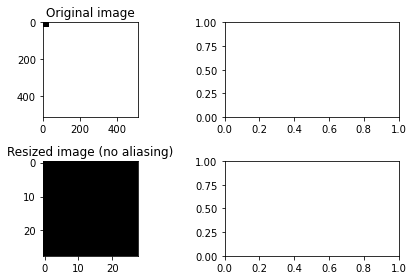

In [11]:
# image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (28,28), anti_aliasing=True)
# image_downscaled = downscale_local_mean(image, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

# ax[1].imshow(image_rescaled, cmap='gray')
# ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

# ax[3].imshow(image_downscaled, cmap='gray')
# ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()